In [ ]:
# Examples of 2-D probability density functions (PDF) estimated using standard histograms and KDE methods

In this script, we compare PDF estimates based on two approaches; the standard histogram method and the Kernel 
Density Estimation method (KDE). 

We generate a 2-D dataset with a gaussian PDF 

## Naive PDF estimator
The probability density $\hat P(x)$ is proportional to the number of data points $x^{t}$ inside the interval $[x-h, x+h[$ 


<blockquote>  $\hat P(x) = \# \{\{x_{1}<x_{1}^{t}\le x_{1}+h \} \cap \{ x_{2}<x_{2}^{t}\le x_{2}+h \}\} $


with the Top Hat (or Boxcar) kernel

<blockquote>  $W(u) =     
    \begin{cases}
      1, & \text{if} |u| < 1 \\
      0, & \text{otherwise}
    \end{cases}$
</blockquote> 
                    

## PDF with kernel methods
The probability density $\hat P(x)$ can be modeled as the convolution of the data distribution with a kernel $K(u)$ designed to
smooth the experimental PDF

<blockquote>  $\hat P(x) = \frac{1}{Nh}\sum_{t=1}^{N} K(\frac{x-x^{t}}{h})$ </blockquote> 
                                 
The level of smoothing is controled by the bandwidth parameter <i>h</i>. 
<br><br>    


Gaussian and epanechikov kernels are popular kernels. Their 1-D and 2-D expressions are:
    
<blockquote>  1-D Gaussian: $K(u)= \frac{1}{\sqrt{2\pi}} \exp [-\frac{u^{2}}{2}]$ </blockquote>
<blockquote>  2-D Gaussian: $K(u)= \frac{1}{2\pi} \exp [-\frac{u^{2}}{2}]$ </blockquote>
<br><br>

    
<blockquote>  1-D Epanechikov: $K(u)= \frac{3}{4}(1-u^{2})$ for $u \in [-1, 1]$ </blockquote>    
<blockquote>  2-D Epanechikov: $K(u)= \frac{15}{8\pi}(1-u^{2})$ for $u \in [0, 1]$ </blockquote>
<br><br>

In this script, we only use the 2-D version as we process 2-D datasets.
  


In [1]:
print(__doc__)

# Authors: Pierre Gravel <pierre.gravel@iid.ulaval.ca>
# License: XXX

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage

from scipy.stats import multivariate_normal
from progress.bar import Bar

import seaborn as sns
sns.set()

Automatically created module for IPython interactive environment


In [74]:
def show_PDF(X):
    
    # Generate a spatial grid where the PDF will be evaluated locally
    x_min, x_max = 0., 4.
    y_min, y_max = 0., 4.
    h = 0.01
    x, y = np.mgrid[x_min:x_max:h, y_min:y_max:h]
    pos = np.dstack((x, y))

    # Generator for the 2-D PDF 
    rv = multivariate_normal(Mu,Sigma)
    
    # Remove datapoints outside figure limits 
    X = X[(X[:,0]>x_min) & (X[:,0]<x_max) & (X[:,1]>y_min) & (X[:,1]<y_max)]

    fig = plt.figure(figsize = (8,8))
    cm = plt.get_cmap('hot')

    ax = fig.add_subplot(111)
    ax.contourf(x, y, rv.pdf(pos),cmap=cm)

    ax.scatter(X[:, 0], X[:, 1], c="w", s=5, linewidth=1, marker="o")

    # Origin of the PDF
    plt.text(Mu[0], Mu[1], '$\mu$', horizontalalignment='center', verticalalignment='center', fontsize=20, color='red')

    ax.set_xlim([x_min,x_max])
    ax.set_ylim([y_min,y_max])
    ax.axis('equal')

    ax.set_xlabel('$x_{1}$',fontsize=18)
    ax.set_ylabel('$x_{2}$',rotation=0,fontsize=18)
    ax.yaxis.set_label_coords(-0.1,0.5)
    ax.xaxis.set_label_coords(0.5, -0.05)

#    plt.savefig(figName, format='png')

    plt.show()

In [ ]:
# Dataset generation
We generate a dataset 

In [87]:
# Parameters
Mu = [2., 2.]

# Covariance matrix
sigma_x1 = 0.45
sigma_x2 = 0.9
rho = 0.9
Sigma = [(sigma_x1**2, rho*sigma_x1*sigma_x2), (rho*sigma_x1*sigma_x2, sigma_x2**2)]


In [ ]:
Create a bivariate normal dataset with npts data points

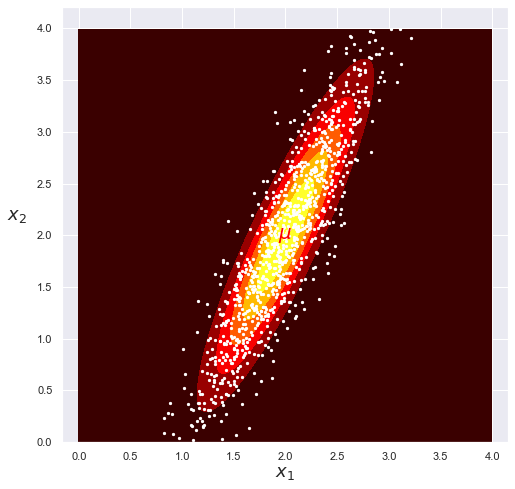

In [88]:
npts = 1000
X = np.random.multivariate_normal(Mu, Sigma, npts)
x = X[:,0]
y = X[:,1]

show_PDF(X)


In [77]:
nbins = 50
xedges = np.linspace(0,4,nbins+1)
yedges = np.linspace(0,4,nbins+1)

pdf_hist, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density=True)
pdf_hist = pdf_hist.T  # Let each row list bins with common y range.

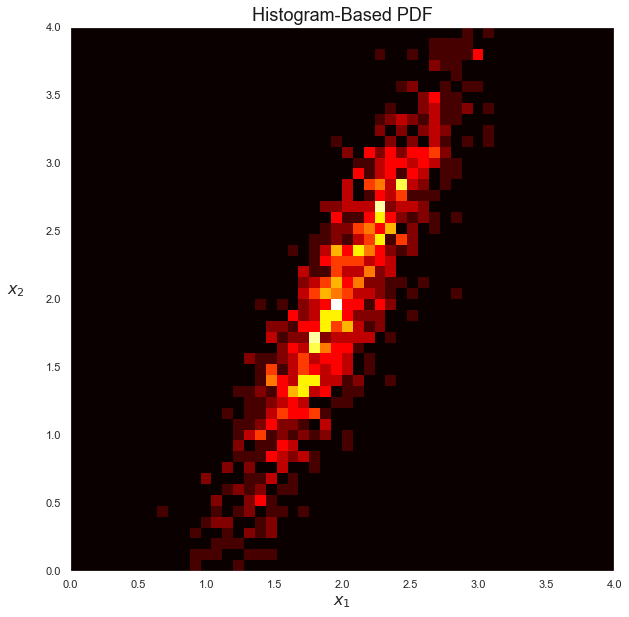

In [108]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
ax.imshow(pdf_hist, interpolation='nearest', origin='low',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='hot')
ax.set_title('Histogram-Based PDF', fontsize=18, color='k')
ax.set_xlabel('$x_{1}$', fontsize=16)
ax.set_ylabel('$x_{2}$', fontsize=16, rotation=0)
ax.yaxis.set_label_coords(-0.1, 0.5) 
ax.grid(None)

In [82]:
x_min, x_max = 0, 4
y_min, y_max = 0, 4

xx, yy = np.meshgrid(np.linspace(x_min, x_max, nbins), np.linspace(y_min, y_max, nbins))
pos = np.dstack((xx, yy)) 
Xgrid = np.c_[xx.ravel(), yy.ravel()]

In [83]:
def compute_KDE_pdf(npts, h_gaussian, h_epanechikov, X, xx, Xgrid):

    pdf_g = np.zeros(xx.shape)
    pdf_e = np.zeros(xx.shape)

    for n in range(npts):    
        dX = (X[n,:] - Xgrid)
        dX2 = dX[:,0]**2 + dX[:,1]**2
        
        u2 = dX2/h_gaussian**2
        pdf_g = pdf_g + gaussian_2D(u2).reshape(xx.shape)

        u2 = dX2/h_epanechikov**2
        pdf_e = pdf_e + epanechikov_2D(u2).reshape(xx.shape)
        
    # Normalisation
    pdf_g = pdf_g/(npts*h_gaussian**2)
    pdf_e = pdf_e/(npts*h_epanechikov**2)
    
    return (pdf_g, pdf_e)
        

# KDE kernels
def gaussian_2D(u2):
    y = np.exp(-u2/2)/(2*np.pi)
    return y

def epanechikov_2D(u2): 
    y = (15/(8*np.pi))*(1-u2)
    indx = np.where(u2>=1)
    y[indx] = 0
    return y

In [84]:
model = multivariate_normal(Mu, Sigma)
pdf_true = model.pdf(pos)

In [115]:
h_gaussian = 0.15
h_epanechikov = 0.3

(pdf_KDE_gauss, pdf_KDE_epa) = compute_KDE_pdf(npts, h_gaussian, h_epanechikov, X, xx, Xgrid)

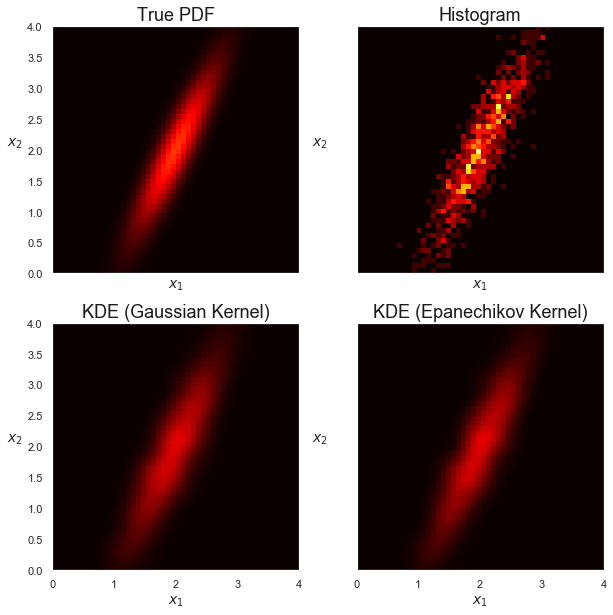

In [118]:
cm = 'hot'
fig, axs = plt.subplots(2,2, figsize=(10, 10), sharex=True, sharey=True) 
for k in range(4):
    if (k==0):
        axs[0,0].imshow(pdf_true, interpolation='nearest', origin='low',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap=cm, vmin=0, vmax=vmax)
        axs[0,0].set_title('True PDF', fontsize=18, color='k')
        axs[0,0].set_xlabel('$x_{1}$', fontsize=14)
        axs[0,0].set_ylabel('$x_{2}$', fontsize=14, rotation=0)
        axs[0,0].yaxis.set_label_coords(-0.15, 0.5) 
        axs[0,0].grid(None)  
    elif (k==1):
        axs[0,1].imshow(pdf_hist, interpolation='nearest', origin='low',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap=cm, vmin=0, vmax=vmax)
        axs[0,1].set_title('Histogram', fontsize=18, color='k')
        axs[0,1].set_xlabel('$x_{1}$', fontsize=14)
        axs[0,1].set_ylabel('$x_{2}$', fontsize=14, rotation=0)
        axs[0,1].yaxis.set_label_coords(-0.15, 0.5) 
        axs[0,1].grid(None)  
    elif (k==2):
        axs[1,0].imshow(pdf_KDE_gauss, interpolation='nearest', origin='low',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap=cm, vmin=0, vmax=vmax)
        axs[1,0].set_title('KDE (Gaussian Kernel)', fontsize=18, color='k')
        axs[1,0].set_xlabel('$x_{1}$', fontsize=14)
        axs[1,0].set_ylabel('$x_{2}$', fontsize=14, rotation=0)
        axs[1,0].yaxis.set_label_coords(-0.15, 0.5) 
        axs[1,0].grid(None)  
    else:
        axs[1,1].imshow(pdf_KDE_epa, interpolation='nearest', origin='low',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap=cm, vmin=0, vmax=vmax)
        axs[1,1].set_title('KDE (Epanechikov Kernel)', fontsize=18, color='k')
        axs[1,1].set_xlabel('$x_{1}$', fontsize=14)
        axs[1,1].set_ylabel('$x_{2}$', fontsize=14, rotation=0)
        axs[1,1].yaxis.set_label_coords(-0.15, 0.5) 
        axs[1,1].grid(None)        
